In [1]:
# Check PyTorch version installed on this system
!python -c "import torch; print(torch.__version__)"

1.13.0+cu116


In [2]:
%%capture
# Download the corresponding PyTorch Geometric module
"""
Assign to TORCH with what you get from the cell above. E.g., export TORCH=1.12.1+cu113
"""
%env TORCH=1.13.0+cu116
!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-geometric

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Let's first import all the things we are gonna need for this task

import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
# torch_geometric only used to load the Cora dataset
from torch_geometric.datasets import Planetoid, TUDataset
from torch_geometric.loader import DataLoader
import torch_geometric.utils as U

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

dataset_node = Planetoid("/tmp/Cora", name="Cora")
dataset_graph = TUDataset(root='data/TUDataset', name='PROTEINS')

# num_nodes = dataset.data.num_nodes
# num_edges = dataset.data.num_edges // 2
# num_features = dataset.num_node_features
# num_classes = dataset.num_classes

# print()
# print(f'Dataset: {dataset}:')
# print('====================')
# print(f'Number of graphs: {len(dataset)}')
# print(f'Number of features: {dataset.num_features}')
# print(f'Number of classes: {dataset.num_classes}')

Processing...
Done!
Extracting data/TUDataset/PROTEINS/PROTEINS.zip
Processing...
Done!


## Node Classification

In [5]:
data_node = dataset_node[0].to(device)
adj_matrix = U.to_dense_adj(data_node.edge_index).squeeze(0)

test_mask_node = []
for i in range(len(adj_matrix)):
  if adj_matrix[i].sum() >= 7:
    test_mask_node.append(True)
  else:
    test_mask_node.append(False)

val_mask_node = []
for i in range(len(adj_matrix)):
  if adj_matrix[i].sum() >= 5 and adj_matrix[i].sum() <= 6:
    val_mask_node.append(True)
  else:
    val_mask_node.append(False)

train_mask_node = []
for i in range(len(adj_matrix)):
  if adj_matrix[i].sum() <= 4:
    train_mask_node.append(True)
  else:
    train_mask_node.append(False)

### GCN

In [40]:
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset_node.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset_node.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


In [46]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

data = dataset_node[0]
data.train_mask = torch.tensor(train_mask_node)
data.test_mask = torch.tensor(test_mask_node)
data.val_mask = torch.tensor(val_mask_node)

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

test_aa = []
for epoch in range(1, 101):
    loss = train()
    test_acc = test()
    test_aa.append(test_acc)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 1.9653
Epoch: 002, Loss: 1.8856
Epoch: 003, Loss: 1.8169
Epoch: 004, Loss: 1.7300
Epoch: 005, Loss: 1.6468
Epoch: 006, Loss: 1.5748
Epoch: 007, Loss: 1.4883
Epoch: 008, Loss: 1.3949
Epoch: 009, Loss: 1.3186
Epoch: 010, Loss: 1.2483
Epoch: 011, Loss: 1.1743
Epoch: 012, Loss: 1.1106
Epoch: 013, Loss: 1.0382
Epoch: 014, Loss: 0.9781
Epoch: 015, Loss: 0.8945
Epoch: 016, Loss: 0.8484
Epoch: 017, Loss: 0.8061
Epoch: 018, Loss: 0.7704
Epoch: 019, Loss: 0.7164
Epoch: 020, Loss: 0.6736
Epoch: 021, Loss: 0.6522
Epoch: 022, Loss: 0.6089
Epoch: 023, Loss: 0.5814
Epoch: 024, Loss: 0.5472
Epoch: 025, Loss: 0.5305
Epoch: 026, Loss: 0.5082
Epoch: 027, Loss: 0.4786
Epoch: 028, Loss: 0.4579
Epoch: 029, Loss: 0.4562
Epoch: 030, Loss: 0.4273
Epoch: 031, Loss: 0.4171
Epoch: 032, Loss: 0.3969
Epoch: 033, Loss: 0.3938
Epoch: 034, Loss: 0.3831
Epoch: 035, Loss: 0.3679
Epoch: 036, Loss: 0.3441
Epoch: 037, Loss: 0.3444
Epoch: 038, Loss: 0.3386
Epoch: 039, Loss: 0.3327
Epoch: 040, Loss: 0.3200


In [8]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8916


In [42]:
from torch_geometric.nn import GATConv


class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, heads=3):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATConv(dataset_node.num_features, hidden_channels, num_heads=heads)  # TODO
        self.conv2 = GATConv(hidden_channels, dataset_node.num_classes, num_heads=heads)  # TODO

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GAT(hidden_channels=8, heads=8)
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test(mask):
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      correct = pred[mask] == data.y[mask]  # Check against ground-truth labels.
      acc = int(correct.sum()) / int(mask.sum())  # Derive ratio of correct predictions.
      return acc

test_bb = []
for epoch in range(1, 101):
    loss = train()
    val_acc = test(data.val_mask)
    test_acc = test(data.test_mask)
    test_bb.append(test_acc)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

GAT(
  (conv1): GATConv(1433, 8, heads=1)
  (conv2): GATConv(8, 7, heads=1)
)
Epoch: 001, Loss: 1.9475, Val: 0.3617, Test: 0.3951
Epoch: 002, Loss: 1.8821, Val: 0.3447, Test: 0.3427
Epoch: 003, Loss: 1.8338, Val: 0.3277, Test: 0.3182
Epoch: 004, Loss: 1.7740, Val: 0.3058, Test: 0.3042
Epoch: 005, Loss: 1.7258, Val: 0.3010, Test: 0.3007
Epoch: 006, Loss: 1.6862, Val: 0.3083, Test: 0.3077
Epoch: 007, Loss: 1.6423, Val: 0.3325, Test: 0.3392
Epoch: 008, Loss: 1.5982, Val: 0.3762, Test: 0.3776
Epoch: 009, Loss: 1.5662, Val: 0.4345, Test: 0.4685
Epoch: 010, Loss: 1.5164, Val: 0.5049, Test: 0.5245
Epoch: 011, Loss: 1.4739, Val: 0.5388, Test: 0.5874
Epoch: 012, Loss: 1.4265, Val: 0.5825, Test: 0.6259
Epoch: 013, Loss: 1.4117, Val: 0.6456, Test: 0.6643
Epoch: 014, Loss: 1.3599, Val: 0.6869, Test: 0.6783
Epoch: 015, Loss: 1.3146, Val: 0.7233, Test: 0.7308
Epoch: 016, Loss: 1.2979, Val: 0.7524, Test: 0.7448
Epoch: 017, Loss: 1.2530, Val: 0.7694, Test: 0.7587
Epoch: 018, Loss: 1.2187, Val: 0.8034,

### GIN

In [43]:
from torch_geometric.nn import GINConv
from torch.nn import Sequential
from torch.nn import Linear
from torch.nn import BatchNorm1d, ReLU

class GIN(torch.nn.Module):
    """GIN"""
    def __init__(self, dim_h):
        super(GIN, self).__init__()
        self.conv1 = GINConv(
            Sequential(Linear(dataset_node.num_node_features, dim_h),
                       BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        self.conv2 = GINConv(
            Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        self.conv3 = GINConv(
            Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        self.lin1 = Linear(dim_h*3, dim_h*3)
        self.lin2 = Linear(dim_h*3, dataset_node.num_classes)

    def forward(self, x, edge_index):
        # Node embeddings 
        h1 = self.conv1(x, edge_index)
        h2 = self.conv2(h1, edge_index)
        h3 = self.conv3(h2, edge_index)

        # Concatenate graph embeddings
        h = torch.cat((h1, h2, h3), dim=1)

        # Classifier
        h = self.lin1(h)
        h = h.relu()
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.lin2(h)
        
        return h


model = GIN(dim_h=64)
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test(mask):
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      correct = pred[mask] == data.y[mask]  # Check against ground-truth labels.
      acc = int(correct.sum()) / int(mask.sum())  # Derive ratio of correct predictions.
      return acc

test_cc = []
for epoch in range(1, 101):
    loss = train()
    val_acc = test(data.val_mask)
    test_acc = test(data.test_mask)
    test_cc.append(test_acc)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

GIN(
  (conv1): GINConv(nn=Sequential(
    (0): Linear(in_features=1433, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): ReLU()
  ))
  (conv2): GINConv(nn=Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): ReLU()
  ))
  (conv3): GINConv(nn=Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): ReLU()
  ))
  (lin1): Linear(in_features=192, out_features=192, bias=True)
  (lin2): Linear(in_features=192, out_features=7, bias=True)
)
Epoch: 001, Loss: 1.9448, V

## Graph Classification

In [16]:
stats = []
for graph_idx in range(len(dataset_graph)):

  data = dataset_graph[graph_idx]  # Get the first graph object.
  adj_matrix = U.to_dense_adj(data.edge_index).squeeze(0)
  std = 0
  for i in range(len(adj_matrix)):
    std += (adj_matrix[i].sum() - 2 * data.num_edges / data.num_nodes) ** 2
  std /= len(adj_matrix)
  std = np.sqrt(std)

  stats.append([data.num_nodes, 
                data.num_edges,
                2 * data.num_edges / data.num_nodes,
                std,
                data.has_isolated_nodes(),
                data.has_self_loops(),
                data.is_undirected()])
stats_df = pd.DataFrame(np.array(stats),
                        columns=['no_nodes', 
                                 'no_edges',
                                 'avg_node_degree',
                                 'std_node_degree',
                                 'has_isolated_nodes',
                                 'has_self_loops',
                                 'is_undirected'])
threshold = 8
train_mask_graph = stats_df[stats_df['avg_node_degree'] < threshold].index.to_list()
test_mask_graph = stats_df[stats_df['avg_node_degree'] >= threshold].index.to_list()

In [17]:
train_g = dataset_graph[train_mask_graph]
test_g = dataset_graph[test_mask_graph]

In [18]:
print(f'Number of training graphs: {len(train_g)}')
print(f'Number of test graphs: {len(test_g)}')

Number of training graphs: 805
Number of test graphs: 308


In [19]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_g, batch_size=64, shuffle=True)
test_loader = DataLoader(test_g, batch_size=64, shuffle=False)

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 6492], x=[1827, 3], y=[64], batch=[1827], ptr=[65])

Step 2:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 10012], x=[2892, 3], y=[64], batch=[2892], ptr=[65])

Step 3:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 8144], x=[2301, 3], y=[64], batch=[2301], ptr=[65])

Step 4:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 7470], x=[2157, 3], y=[64], batch=[2157], ptr=[65])

Step 5:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 11718], x=[3407, 3], y=[64], batch=[3407], ptr=[65])

Step 6:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 10126], x=[2865, 3], y=[64], batch=[2865], ptr=[65])

Step 7:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 8744], x=[2522, 3], y=[64], batch=[2522], ptr=[65])

Step 8:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 6940], x=[1917, 3], y=[64]

### GCN

In [20]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset_graph.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset_graph.num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

model = GCN(hidden_channels=64)
print(model)

GCN(
  (conv1): GCNConv(3, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [26]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x, data.edge_index, data.batch)  
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.

test_a = []
for epoch in range(1, 171):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    test_a.append(test_acc)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Train Acc: 0.6410, Test Acc: 0.6299
Epoch: 002, Train Acc: 0.6311, Test Acc: 0.7045
Epoch: 003, Train Acc: 0.5975, Test Acc: 0.7208
Epoch: 004, Train Acc: 0.6857, Test Acc: 0.7403
Epoch: 005, Train Acc: 0.6758, Test Acc: 0.7273
Epoch: 006, Train Acc: 0.6596, Test Acc: 0.7208
Epoch: 007, Train Acc: 0.6596, Test Acc: 0.6948
Epoch: 008, Train Acc: 0.7118, Test Acc: 0.7403
Epoch: 009, Train Acc: 0.6807, Test Acc: 0.7273
Epoch: 010, Train Acc: 0.6981, Test Acc: 0.7370
Epoch: 011, Train Acc: 0.6062, Test Acc: 0.6948
Epoch: 012, Train Acc: 0.6696, Test Acc: 0.7240
Epoch: 013, Train Acc: 0.6944, Test Acc: 0.7370
Epoch: 014, Train Acc: 0.6733, Test Acc: 0.7305
Epoch: 015, Train Acc: 0.7068, Test Acc: 0.7500
Epoch: 016, Train Acc: 0.6745, Test Acc: 0.7240
Epoch: 017, Train Acc: 0.6870, Test Acc: 0.7370
Epoch: 018, Train Acc: 0.6621, Test Acc: 0.7273
Epoch: 019, Train Acc: 0.6596, Test Acc: 0.7143
Epoch: 020, Train Acc: 0.6683, Test Acc: 0.7338
Epoch: 021, Train Acc: 0.6994, Test Acc:

### GAT

In [22]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch_geometric.nn import global_mean_pool


class GAT(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GAT, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GATConv(dataset_graph.num_node_features, hidden_channels, num_heads=3)
        self.conv2 = GATConv(hidden_channels, hidden_channels, num_heads=3)
        self.conv3 = GATConv(hidden_channels, hidden_channels, num_heads=3)
        self.lin = Linear(hidden_channels, dataset_graph.num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

model = GAT(hidden_channels=64)
print(model)

GAT(
  (conv1): GATConv(3, 64, heads=1)
  (conv2): GATConv(64, 64, heads=1)
  (conv3): GATConv(64, 64, heads=1)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [27]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GAT(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x, data.edge_index, data.batch)  
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.

test_b = []
for epoch in range(1, 171):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    test_b.append(test_acc)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Train Acc: 0.6124, Test Acc: 0.6039
Epoch: 002, Train Acc: 0.6733, Test Acc: 0.7110
Epoch: 003, Train Acc: 0.7130, Test Acc: 0.7305
Epoch: 004, Train Acc: 0.7043, Test Acc: 0.7273
Epoch: 005, Train Acc: 0.6571, Test Acc: 0.7143
Epoch: 006, Train Acc: 0.6907, Test Acc: 0.7273
Epoch: 007, Train Acc: 0.6894, Test Acc: 0.7175
Epoch: 008, Train Acc: 0.6807, Test Acc: 0.7370
Epoch: 009, Train Acc: 0.6795, Test Acc: 0.7240
Epoch: 010, Train Acc: 0.6957, Test Acc: 0.7403
Epoch: 011, Train Acc: 0.6720, Test Acc: 0.7175
Epoch: 012, Train Acc: 0.7006, Test Acc: 0.7175
Epoch: 013, Train Acc: 0.6758, Test Acc: 0.7240
Epoch: 014, Train Acc: 0.6547, Test Acc: 0.7208
Epoch: 015, Train Acc: 0.7031, Test Acc: 0.7208
Epoch: 016, Train Acc: 0.7019, Test Acc: 0.7240
Epoch: 017, Train Acc: 0.7019, Test Acc: 0.7273
Epoch: 018, Train Acc: 0.6919, Test Acc: 0.7305
Epoch: 019, Train Acc: 0.6870, Test Acc: 0.7175
Epoch: 020, Train Acc: 0.7031, Test Acc: 0.7338
Epoch: 021, Train Acc: 0.7006, Test Acc:

### GIN

In [ ]:
from torch_geometric.nn.fx import Sequential
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GINConv
from torch_geometric.nn import global_add_pool
from torch.nn import Sequential, BatchNorm1d, ReLU


class GIN(torch.nn.Module):
    """GIN"""
    def __init__(self, dim_h):
        super(GIN, self).__init__()
        self.conv1 = GINConv(
            Sequential(Linear(dataset_graph.num_node_features, dim_h),
                       BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        self.conv2 = GINConv(
            Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        self.conv3 = GINConv(
            Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        self.lin1 = Linear(dim_h*3, dim_h*3)
        self.lin2 = Linear(dim_h*3, dataset_graph.num_classes)

    def forward(self, x, edge_index, batch):
        # Node embeddings 
        h1 = self.conv1(x, edge_index)
        h2 = self.conv2(h1, edge_index)
        h3 = self.conv3(h2, edge_index)

        # Graph-level readout
        h1 = global_add_pool(h1, batch)
        h2 = global_add_pool(h2, batch)
        h3 = global_add_pool(h3, batch)

        # Concatenate graph embeddings
        h = torch.cat((h1, h2, h3), dim=1)

        # Classifier
        h = self.lin1(h)
        h = h.relu()
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.lin2(h)
        
        return h, F.log_softmax(h, dim=1)

model = GIN(dim_h=64)
print(model)

In [28]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GIN(dim_h=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out[0], data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x, data.edge_index, data.batch)  
         pred = out[1].argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.

test_c = []
for epoch in range(1, 171):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    test_c.append(test_acc)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Train Acc: 0.6683, Test Acc: 0.7370
Epoch: 002, Train Acc: 0.7118, Test Acc: 0.7792
Epoch: 003, Train Acc: 0.6907, Test Acc: 0.7468
Epoch: 004, Train Acc: 0.7168, Test Acc: 0.7922
Epoch: 005, Train Acc: 0.7429, Test Acc: 0.7630
Epoch: 006, Train Acc: 0.7429, Test Acc: 0.7662
Epoch: 007, Train Acc: 0.7255, Test Acc: 0.7532
Epoch: 008, Train Acc: 0.7031, Test Acc: 0.6916
Epoch: 009, Train Acc: 0.7342, Test Acc: 0.7630
Epoch: 010, Train Acc: 0.7292, Test Acc: 0.7857
Epoch: 011, Train Acc: 0.7491, Test Acc: 0.7695
Epoch: 012, Train Acc: 0.7217, Test Acc: 0.7013
Epoch: 013, Train Acc: 0.7217, Test Acc: 0.7110
Epoch: 014, Train Acc: 0.7602, Test Acc: 0.7630
Epoch: 015, Train Acc: 0.7528, Test Acc: 0.7565
Epoch: 016, Train Acc: 0.7665, Test Acc: 0.7597
Epoch: 017, Train Acc: 0.7416, Test Acc: 0.7403
Epoch: 018, Train Acc: 0.7590, Test Acc: 0.7370
Epoch: 019, Train Acc: 0.7329, Test Acc: 0.7695
Epoch: 020, Train Acc: 0.7578, Test Acc: 0.7532
Epoch: 021, Train Acc: 0.7453, Test Acc:

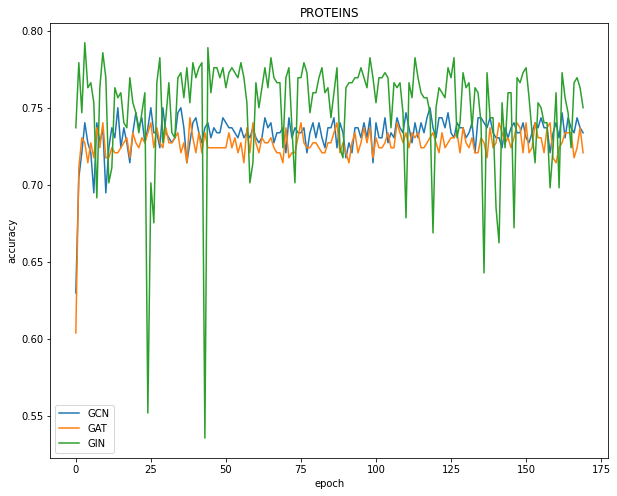

In [36]:
fig = plt.figure(figsize=(10,8))
plt.title("PROTEINS")
plt.plot(test_a)
plt.plot(test_b)
plt.plot(test_c)
plt.legend(['GCN', 'GAT', 'GIN'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

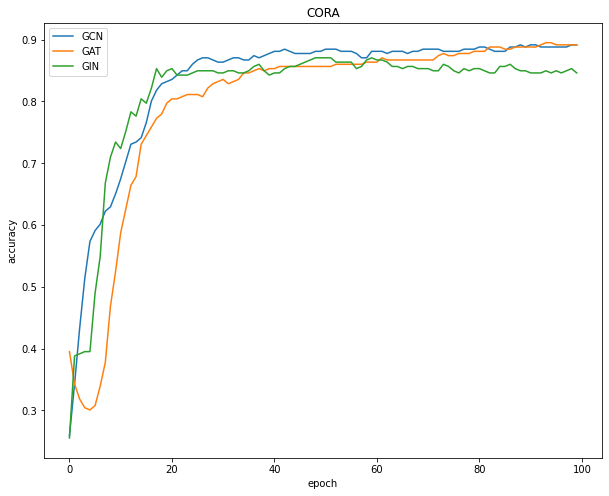

In [48]:
fig = plt.figure(figsize=(10,8))
plt.title("CORA")
plt.plot(test_aa)
plt.plot(test_bb)
plt.plot(test_cc)
plt.legend(['GCN', 'GAT', 'GIN'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [47]:
test_aa

[0.25874125874125875,
 0.34265734265734266,
 0.43356643356643354,
 0.513986013986014,
 0.5734265734265734,
 0.5909090909090909,
 0.6013986013986014,
 0.6223776223776224,
 0.6293706293706294,
 0.6503496503496503,
 0.6748251748251748,
 0.7027972027972028,
 0.7307692307692307,
 0.7342657342657343,
 0.7412587412587412,
 0.7657342657342657,
 0.8006993006993007,
 0.8181818181818182,
 0.8286713286713286,
 0.8321678321678322,
 0.8356643356643356,
 0.8426573426573427,
 0.8496503496503497,
 0.8496503496503497,
 0.8601398601398601,
 0.8671328671328671,
 0.8706293706293706,
 0.8706293706293706,
 0.8671328671328671,
 0.8636363636363636,
 0.8636363636363636,
 0.8671328671328671,
 0.8706293706293706,
 0.8706293706293706,
 0.8671328671328671,
 0.8671328671328671,
 0.8741258741258742,
 0.8706293706293706,
 0.8741258741258742,
 0.8776223776223776,
 0.8811188811188811,
 0.8811188811188811,
 0.8846153846153846,
 0.8811188811188811,
 0.8776223776223776,
 0.8776223776223776,
 0.8776223776223776,
 0.87762237